In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as pl

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


In [14]:
df_modelo = pd.read_csv(r'C:\Users\Thyana De Lara\Documents\TCC\modelo_vendas_forecasting\versao_2\2.1.dados_limpos.csv')

In [17]:
df_modelo = df_modelo.sort_values(['store_nbr', 'family_top6', 'ano', 'mes'])

# Criar lags de 3 mês
df_modelo['dias_ativos_venda_lag3'] = df_modelo.groupby(['store_nbr', 'family_top6'])['dias_ativos_venda'].transform(lambda x: x.shift(1).rolling(3).mean())

# Opcional: preencher os nulos com zero (ou dropar depois)
df_modelo['dias_ativos_venda_lag3'] = df_modelo['dias_ativos_venda_lag3'].fillna(0)

In [18]:
# Recriar as colunas que não foram computadas antes da falha
df_modelo['quarter'] = df_modelo['mes'].apply(lambda x: (x - 1) // 3 + 1)
df_modelo['has_promo'] = (df_modelo['onpromotion'] > 0).astype(int)

In [224]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92621 entries, 3 to 92618
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    92621 non-null  object        
 1   store_nbr               92621 non-null  int64         
 2   family                  92621 non-null  object        
 3   sales                   92621 non-null  float64       
 4   onpromotion             92621 non-null  int64         
 5   ano                     92621 non-null  int64         
 6   mes                     92621 non-null  int64         
 7   qtd_feriados            92621 non-null  float64       
 8   volume                  69097 non-null  float64       
 9   dias_ativos_venda       92621 non-null  float64       
 10  family_top6             92621 non-null  object        
 11  ano_mes                 92621 non-null  datetime64[ns]
 12  outlier                 92621 non-null  bool       

In [19]:
df_modelo['log_sales'] = np.log1p(df_modelo['sales'])

In [20]:
# Flags para famílias com alto erro
df_modelo['is_bakery'] = (df_modelo['family_top6'] == 'BREAD/BAKERY').astype(int)
df_modelo['is_produce'] = (df_modelo['family_top6'] == 'PRODUCE').astype(int)
df_modelo['is_cleaning'] = (df_modelo['family_top6'] == 'CLEANING').astype(int)

# Flag para lojas com erro alto
lojas_erro_alto = [49, 3, 44, 45]
df_modelo['loja_erro_alto'] = df_modelo['store_nbr'].isin(lojas_erro_alto).astype(int)


In [21]:
# Colunas numéricas e categóricas da sua base
colunas_numericas = ['onpromotion', 'qtd_feriados', 'ano', 'mes', 'dias_ativos_venda','dias_ativos_venda_lag3', 'quarter','has_promo', 'is_bakery', 'is_produce', 'is_cleaning', 'loja_erro_alto']
colunas_categoricas = ['store_nbr', 'family_top6'] 

# Juntar as colunas que serão usadas
colunas_usadas = colunas_numericas + colunas_categoricas

# Selecionar os dados
X = df_modelo[colunas_usadas]

# One-Hot Encoding para variáveis categóricas
X_encoded = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)

# Normalizar colunas numéricas com MinMaxScaler
scaler = MinMaxScaler()
X_encoded[colunas_numericas] = scaler.fit_transform(X_encoded[colunas_numericas])

# Variável alvo
y = df_modelo['log_sales']

In [22]:
# Período de treino
X_treino = X_encoded[(df_modelo['ano'] >= 2013) & (df_modelo['ano'] <= 2015)]
Y_treino = df_modelo.loc[X_treino.index, 'log_sales'] 

# Período de teste
X_teste = X_encoded[(df_modelo['ano'] >= 2016) ]
Y_teste = df_modelo.loc[X_teste.index, 'log_sales']  # Mesmo target usado acima
print(f"Treino: {X_treino.shape}, Teste: {X_teste.shape}")

Treino: (61188, 71), Teste: (33156, 71)


In [250]:
del xgb_model

In [238]:
# Lista de parâmetros para testar
n_estimators_list = [50, 100, 200, 300]
max_depth_list = [5, 10, 20, 30, None]

# Armazenar os resultados
resultados = []

# Loop pelas combinações
for n in n_estimators_list:
    for depth in max_depth_list:
        modelo = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=42, n_jobs=-1)
        modelo.fit(X_treino, Y_treino)

        y_pred = modelo.predict(X_teste)

        mae = mean_absolute_error(Y_teste, y_pred)
        rmse = np.sqrt(mean_squared_error(Y_teste, y_pred))
        r2 = r2_score(Y_teste, y_pred)

        resultados.append({
            'n_estimators': n,
            'max_depth': depth,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

# Converter os resultados em DataFrame
df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values('RMSE'))

    n_estimators  max_depth       MAE      RMSE        R2
12           200       20.0  0.603281  0.920224  0.904955
17           300       20.0  0.603338  0.920525  0.904892
13           200       30.0  0.597790  0.920785  0.904839
18           300       30.0  0.597561  0.920900  0.904815
7            100       20.0  0.605000  0.922168  0.904553
14           200        NaN  0.597992  0.922729  0.904436
8            100       30.0  0.599944  0.922801  0.904421
19           300        NaN  0.598073  0.923070  0.904366
2             50       20.0  0.605865  0.924158  0.904140
9            100        NaN  0.599954  0.924273  0.904116
3             50       30.0  0.600425  0.925064  0.903952
4             50        NaN  0.600277  0.926195  0.903717
16           300       10.0  0.633168  0.931627  0.902584
11           200       10.0  0.633703  0.932222  0.902460
1             50       10.0  0.633756  0.932407  0.902421
6            100       10.0  0.634025  0.932591  0.902383
5            1

In [240]:
# Parâmetros a testar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Modelo base
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Grid Search com validação cruzada
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                    scoring='neg_root_mean_squared_error',
                    cv=3, verbose=1)

grid.fit(X_treino, Y_treino)

# Melhor combinação
print("Melhores parâmetros encontrados:", grid.best_params_)
print("Melhor RMSE (negativo):", grid.best_score_)

# Previsão no conjunto de teste
y_pred = grid.best_estimator_.predict(X_teste)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores parâmetros encontrados: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.8}
Melhor RMSE (negativo): -0.7025019511063588


In [23]:
# Função para avaliação
def avaliar_modelo(nome, modelo):
    modelo.fit(X_treino, Y_treino)
    y_pred = modelo.predict(X_teste)
    return {
        'Modelo': nome,
        'MAE': mean_absolute_error(Y_teste, y_pred),
        'RMSE': mean_squared_error(Y_teste, y_pred, squared=False),
        'R2': r2_score(Y_teste, y_pred)
    }

# Testar dois modelos
resultados = []
resultados.append(avaliar_modelo("RandomForest", RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)))
resultados.append(avaliar_modelo("XGBoost", XGBRegressor(n_estimators=200,max_depth=15 ,learning_rate=0.05, subsample=0.8, colsample_bytree=1, random_state=42, n_jobs=-1)))

c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

         Modelo       MAE      RMSE        R2
0  RandomForest  0.619966  0.941985  0.900101
1       XGBoost  0.605243  0.931350  0.902344


c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Métricas de Erro do Modelo:
MAE:  2,031.74
RMSE: 4,155.01
R²:   0.8212


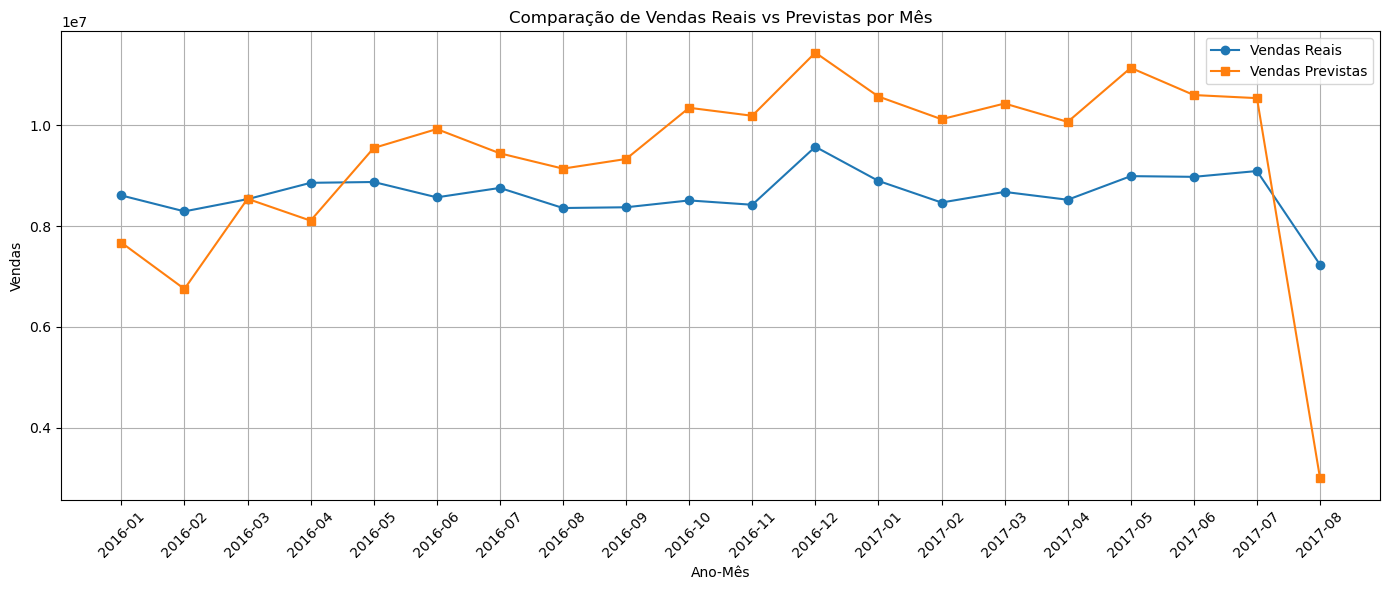

In [25]:
# Obter as previsões do melhor modelo (ex: XGBoost)
xgb_model = XGBRegressor(n_estimators=200,max_depth=15 ,learning_rate=0.05, subsample=0.8, colsample_bytree=1, random_state=42, n_jobs=-1)
xgb_model.fit(X_treino, Y_treino)
y_pred_log = xgb_model.predict(X_teste)

# Reverter o log para obter as vendas reais
y_pred_real = np.expm1(y_pred_log)
y_pred_real = np.clip(y_pred_real, 0, None)  # impede valores negativos

# Reverter o target real para mesma escala
y_real = np.expm1(Y_teste)

# Construir DataFrame com ano, mês e vendas
df_resultado = df_modelo.loc[Y_teste.index, ['ano', 'mes']].copy()
df_resultado['sales_real'] = y_real
df_resultado['sales_prevista'] = y_pred_real

# Agregar por mês
df_mensal = df_resultado.groupby(['ano', 'mes'])[['sales_real', 'sales_prevista']].sum().reset_index()

mae = mean_absolute_error(y_real, y_pred_real)
rmse = mean_squared_error(y_real, y_pred_real, squared=False)
r2 = r2_score(y_real, y_pred_real)

print("Métricas de Erro do Modelo:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.4f}")


# Plotar o gráfico
# Criar coluna de ano-mês para ordenação e visualização
df_mensal['ano_mes'] = df_mensal['ano'].astype(str) + '-' + df_mensal['mes'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))
plt.plot(df_mensal['ano_mes'], df_mensal['sales_real'], marker='o', label='Vendas Reais')
plt.plot(df_mensal['ano_mes'], df_mensal['sales_prevista'], marker='s', label='Vendas Previstas')
plt.title('Comparação de Vendas Reais vs Previstas por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🔍 Métricas de Erro (LOG):
MAE (log):  0.5812
RMSE (log): 0.9005
R² (log):   0.9090


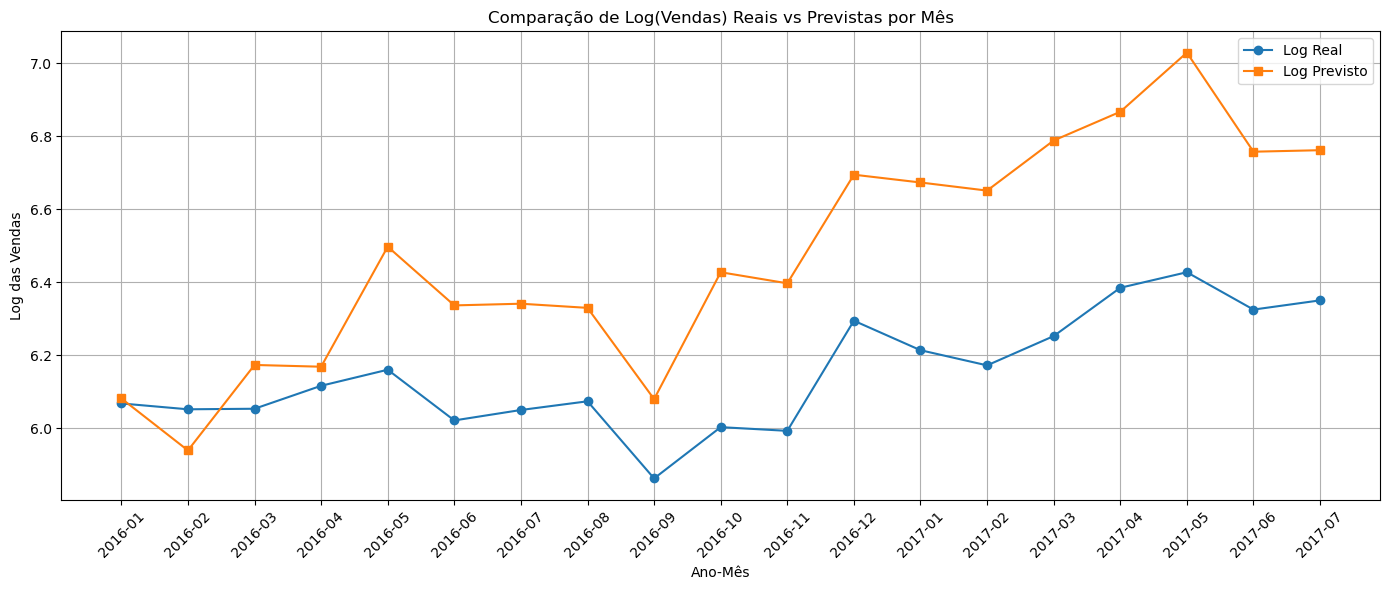

In [252]:
# Criar DataFrame com resultados no log
df_resultado_log = df_modelo.loc[Y_teste.index, ['ano', 'mes']].copy()
df_resultado_log['log_real'] = Y_teste
df_resultado_log['log_previsto'] = y_pred_log

# Agregar por mês (usando média dos logs para não distorcer)
df_mensal_log = df_resultado_log.groupby(['ano', 'mes'])[['log_real', 'log_previsto']].mean().reset_index()

# Métricas no log
mae_log = mean_absolute_error(Y_teste, y_pred_log)
rmse_log = mean_squared_error(Y_teste, y_pred_log, squared=False)
r2_log = r2_score(Y_teste, y_pred_log)

print("🔍 Métricas de Erro (LOG):")
print(f"MAE (log):  {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log):   {r2_log:.4f}")

# Criar coluna de ano-mês
df_mensal_log['ano_mes'] = df_mensal_log['ano'].astype(str) + '-' + df_mensal_log['mes'].astype(str).str.zfill(2)

# Plot em escala log
plt.figure(figsize=(14, 6))
plt.plot(df_mensal_log['ano_mes'], df_mensal_log['log_real'], marker='o', label='Log Real')
plt.plot(df_mensal_log['ano_mes'], df_mensal_log['log_previsto'], marker='s', label='Log Previsto')
plt.title('Comparação de Log(Vendas) Reais vs Previstas por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Log das Vendas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [253]:
df_resultado['erro_absoluto'] = np.abs(df_resultado['sales_real'] - df_resultado['sales_prevista'])

# Erro médio por família
erro_por_familia = df_resultado.join(df_modelo[['family_top6']])
print("\nErro médio por família:")
print(erro_por_familia.groupby('family_top6')['erro_absoluto'].mean().sort_values(ascending=False))

# Erro médio por loja
erro_por_loja = df_resultado.join(df_modelo[['store_nbr']])
print("\nErro médio por loja:")
print(erro_por_loja.groupby('store_nbr')['erro_absoluto'].mean().sort_values(ascending=False))



Erro médio por família:
family_top6
BEVERAGES       9176.487587
DAIRY           5295.078358
GROCERY I       4872.991529
PRODUCE         4164.518708
CLEANING        4047.436555
BREAD/BAKERY    3294.139707
Outros          1621.801379
Name: erro_absoluto, dtype: float64

Erro médio por loja:
store_nbr
44    4480.446111
45    4228.475305
3     4161.204810
46    3770.502164
47    3536.582628
51    3319.769382
49    3263.381198
48    3215.209012
11    2517.238563
7     2516.850410
8     2483.209182
9     2438.392580
50    2276.990148
1     2236.177744
24    2227.461055
6     2050.640052
22    1965.648917
20    1934.714295
2     1924.441144
17    1816.910034
28    1811.782691
5     1806.373795
31    1796.982862
39    1753.963766
53    1733.409677
37    1707.291883
14    1707.197620
33    1672.540518
15    1667.124594
38    1663.160985
42    1660.305182
23    1654.611545
34    1626.895431
27    1621.056181
4     1613.030843
16    1608.995675
36    1572.695425
25    1553.980761
54    1537.9826

In [234]:
df_teste = df_modelo.loc[X_teste.index].copy()
df_teste['y_real'] = y_real
df_teste['y_pred'] = y_pred_real
df_teste['erro'] = df_teste['y_pred'] - df_teste['y_real']

df_teste.groupby('family_top6')['erro'].mean().sort_values()


family_top6
PRODUCE        -7901.039667
BEVERAGES      -7813.682885
GROCERY I      -5936.497802
DAIRY          -5608.035118
CLEANING       -2799.494532
BREAD/BAKERY   -1533.765728
Outros           370.210110
Name: erro, dtype: float64

In [210]:

df_resultado['erro'] = df_resultado['sales_prevista'] - df_resultado['sales_real']
df_resultado.groupby(['ano', 'mes'])['erro'].describe()


count         mean          std           min          25%  \
ano  mes                                                                
2016 1    1657.0 -1349.934557  4768.396520 -37240.453087  -683.707199   
     2    1664.0 -2273.509440  5600.534870 -43372.824850 -2358.079154   
     3    1661.0  -667.221584  4246.608143 -33359.867475  -118.432617   
     4    1657.0 -1371.724601  4573.607349 -35764.314253  -832.164703   
     5    1656.0  -425.619535  4244.408232 -33444.893212  -225.232727   
     6    1666.0   279.092424  4115.700723 -28551.611328   -11.262364   
     7    1659.0    49.225303  4008.450811 -32729.151883   -14.809383   
     8    1661.0    99.924731  4383.528289 -48370.464600   -26.894958   
     9    1666.0   349.418263  3428.964231 -23855.296875   -20.155052   
     10   1660.0   772.326721  3926.011336 -27135.501953    -1.354857   
     11   1655.0   612.907445  4060.058478 -25252.333422    -1.031954   
     12   1637.0   505.254837  5077.680845 -38704.792951   -15.752319   
2017 1    1648.0    31.403516  4600.070619 -37596.007211    -4.221126   
     2    1658.0 -1534.585613  5420.478114 -40735.003259 -1411.731144   
     3    1644.0   165.988492  4520.489922 -36113.364791    -2.355803   
     4    1644.0   226.532771  4365.042176 -36913.858422   -17.736226   
     5    1643.0   342.104717  4735.233680 -33370.013119    -1.174936   
     6    1653.0   531.280761  4062.872602 -28076.433884    -3.260036   
     7    1644.0   582.097554  4235.983602 -25747.862969    -2.490865   

                 50%          75%           max  
ano  mes                                         
2016 1      0.004210   240.795837  13001.581391  
     2     -5.085163    45.349579  12159.927734  
     3      1.950275   450.949158  15178.253906  
     4      0.028859   103.239243  11715.667969  
     5      5.285327   574.819030  12253.854269  
     6     12.778992   988.226135  24302.868989  
     7     19.937393   994.393799  19280.050781  
     8     20.002396   832.488158  39365.535156  
     9      4.679634   827.342590  30024.029297  
     10    76.152168  2045.674072  20071.683594  
     11    40.642263  1803.645508  24380.074219  
     12    28.122742  1828.155273  29101.697266  
2017 1     76.898949  1300.446350  20522.326172  
     2      0.035506   273.951942  17196.921875  
     3    113.803589  1386.108521  16853.500000  
     4     85.757729  1348.327271  17983.042969  
     5    216.616547  1793.787231  27710.009766  
     6    102.747559  1770.742187  25932.208984  
     7    114.722771  1389.847153  26579.904297

In [254]:
def cross_validate_model(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses, r2s = [], [], []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        maes.append(mean_absolute_error(y_test, y_pred))
        rmses.append(mean_squared_error(y_test, y_pred, squared=False))
        r2s.append(r2_score(y_test, y_pred))

        print(f"\n📊 Fold {fold + 1}")
        print(f"MAE: {maes[-1]:,.2f}")
        print(f"RMSE: {rmses[-1]:,.2f}")
        print(f"R²: {r2s[-1]:.4f}")

    print("\n🔎 MÉDIAS GERAIS:")
    print(f"MAE médio: {np.mean(maes):,.2f}")
    print(f"RMSE médio: {np.mean(rmses):,.2f}")
    print(f"R² médio: {np.mean(r2s):.4f}")


In [255]:

# Chamar a função
cross_validate_model(xgb_model, X_encoded, df_modelo['sales'])  # ou log_sales se ainda estiver usando log


c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Fold 1
MAE: 2,133.47
RMSE: 5,053.89
R²: 0.6113


c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Fold 2
MAE: 1,521.39
RMSE: 3,747.51
R²: 0.7965


c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Fold 3
MAE: 1,584.28
RMSE: 3,669.67
R²: 0.8233


c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Fold 4
MAE: 1,608.78
RMSE: 3,594.46
R²: 0.8501

📊 Fold 5
MAE: 2,979.02
RMSE: 6,710.90
R²: 0.5971

🔎 MÉDIAS GERAIS:
MAE médio: 1,965.39
RMSE médio: 4,555.29
R² médio: 0.7357


c:\Users\Thyana De Lara\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


100%|===================| 31420/31433 [23:41<00:00]        

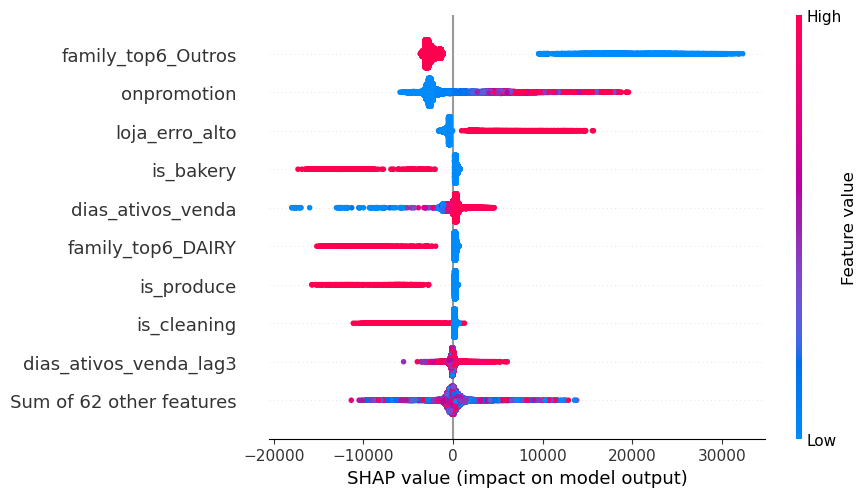

In [256]:
import shap

X_teste = X_teste.astype('float64')
# Criar o explicador
explainer = shap.Explainer(xgb_model, X_teste)

# Calcular os valores SHAP
shap_values = explainer(X_teste)

# Resumo gráfico geral
shap.plots.beeswarm(shap_values)


INTERPRETAÇÃO ESPECÍFICA DO SEU GRÁFICO:
1. onpromotion → Feature mais impactante
Valores altos (vermelho) estão puxando as previsões para a direita → aumentam as vendas previstas

Faz total sentido: quando tem mais promoção, o modelo prevê mais vendas.

2. tkm_lag3
Também tem um impacto relevante. Valores altos de TKM do passado tendem a aumentar a previsão atual → indica que o modelo aprendeu padrão de preço médio anterior influencia venda atual.

3. dias_ativos_venda
Quando o dias_ativos_venda está alto (vermelho), geralmente puxa a previsão pra cima.

Quando o dias_ativos_venda é baixo (azul), puxa para baixo → intuitivo: o modelo reconhece que mais itens vendidos significam mais receita.

4. dias_ativos_venda_lag3
Mesmo raciocínio: dias_ativos_venda de 3 meses atrás também está influenciando positivamente as previsões.

5. mes
Variações no mês também têm impacto, mas não tão fortes.

Mostra que o modelo está considerando sazonalidade (alguns meses vendem mais).

6. family_top6_Outros
Quando o produto está na categoria “Outros”, parece diminuir a previsão em relação às top categorias.

Azul à esquerda → itens com baixa relevância de venda.

7. qtd_feriados
Tem impacto mais discreto. Pode ser positivo ou negativo dependendo do produto — em alguns casos feriados aumentam as vendas, em outros não.

8. store_nbr_3
Mostra que a loja 3 tem um comportamento diferente (impacto específico da unidade).

Algumas lojas vendem bem, outras puxam a previsão para baixo.

9. family_top6_BREAD/BAKERY
Essa família em específico puxa bastante a previsão pra cima quando presente — o modelo entendeu que essa categoria vende bem.

10. Sum of 60 other features
As outras variáveis restantes têm baixo impacto individual, mas somadas ainda contribuem um pouco.

A análise SHAP revelou que as variáveis onpromotion, tkm_lag3 e dias_ativos_venda são os principais determinantes das previsões de vendas. Valores altos dessas variáveis aumentam significativamente a previsão, o que está alinhado com a lógica de negócio. A presença da categoria BREAD/BAKERY e o histórico de dias_ativos_venda também foram identificados como fatores relevantes, enquanto categorias genéricas como Outros reduziram a previsão.